In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

/Users/peng/miniforge3/envs/numpyro/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/peng/miniforge3/envs/numpyro/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/Users/peng/miniforge3/envs/numpyro/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


### Lec3 Hierarchical Modeling of Odd-Type

"to account for within patient correlation we will use a mixed effects model that includes inter-patient variation in the model parameters"

This is the VTE accurrence meta-analysis example in Lec3. (Youtube Lecture video: Lab3)

#### Likelihood
$$N_{VTE,ij} \sim Binomial(p_{VTE,ij}, n_{ij})$$
$$logit(p_{VTE,ij}) = E_{plc,j} + E_{drug,ij}$$
$$E_{drug,ij} = beta * log(D_{ij} + 1)$$

- $N_{VTE,ij}$: the number of patients experiencing VTE in $i^{th}$ treatment arm of $j^{th}$ study
- $p_{VTE,ij}$: the probability of VTE occurence for subjects in $i^{th}$ treatment arm of $j^{th}$ study
- $n_{ij}$: the total number of patients in  $i^{th}$ treatment arm of $j^{th}$ study
- $D_{ij}$: the investigational drug in $i^{th}$ treatment arm of $j^{th}$ study

#### Priors
$$E_{plc,j} \sim Normal(\mu_{plc}, \sigma^2)$$
$$\beta \sim Normal(0, 10^6)$$

#### Hyperpriors
$$\mu_p \sim Normal(logit(0.45), 0.1^2)$$
$$log(\sigma) \sim Normal(log(0.4), 0.5^2)$$

In [3]:
data = pd.read_csv('data/Fxa metadata.csv')
data = data[data['event type']=='vte']
data = data[['study', 'drug', 'daily dose', 'surgery', 'events', 'n']]
data

FileNotFoundError: [Errno 2] No such file or directory: 'data/Fxa metadata.csv'

In [3]:
# x1 subset in lab3 code
thr_data = data.loc[(data['surgery'] == 'thr') & (data['study']==5)]

# x2 subset in lab3 code
tkr_data = data.loc[(data['surgery'] == 'tkr') & (data['study']==5)]
tkr_data = tkr_data[['daily dose', 'drug', 'events', 'n']]
tkr_data.columns = ['daily dose', 'drug', 'events2', 'n2']

# merge thr_data and tkr_data using 'daily dose' and 'drug' as index
merged_data = pd.merge(thr_data, tkr_data, how='left', on=['daily dose', 'drug'])
merged_data['events'] = merged_data['events'] + merged_data['events2']
merged_data['n'] = merged_data['n'] + merged_data['n2']
merged_data['surgery'] = 'both'
merged_data.drop(columns=['events2', 'n2'], inplace=True)
merged_data = pd.concat([merged_data, data[data['study']!=5]])
merged_data['frac'] = merged_data['events'] / merged_data['n']

merged_data

,study,drug,daily dose,surgery,events,n,frac
0,5,LY517717,25,both,11,26,0.423077
1,5,LY517717,50,both,8,20,0.400000
2,5,LY517717,75,both,12,22,0.545455
3,5,LY517717,100,both,13,69,0.188406
4,5,LY517717,125,both,15,80,0.187500
5,5,LY517717,150,both,12,77,0.155844
6,5,enoxaparin,40,both,14,66,0.212121
0,1,rivaroxaban,5,tkr,20,63,0.317460
1,1,rivaroxaban,10,tkr,23,57,0.403509
2,1,rivaroxaban,20,tkr,14,60,0.233333


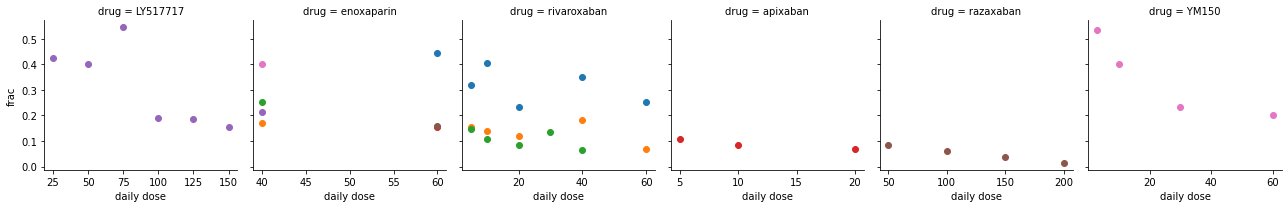

In [4]:
facet = sns.FacetGrid(merged_data, col='drug', hue='study', sharex=False)
facet.map(plt.scatter, 'daily dose', 'frac')

In [5]:
n_study = merged_data['study'].unique().max()
idx_study = merged_data['study'].values - 1

n_vte = merged_data['events'].values
n = merged_data['n'].values
dose = merged_data['daily dose'].values

n_drug = merged_data['drug'].unique().shape[0]
idx_drug = pd.Categorical(merged_data['drug']).codes
idx_drug

array([0, 0, 0, 0, 0, 0, 3, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 3, 5, 5, 5,
       5, 5, 3, 2, 2, 2, 3, 4, 4, 4, 4, 3, 1, 1, 1, 1, 3], dtype=int8)

In [6]:
merged_data.shape

(39, 7)

In [13]:
def model(obs=None):
    # hyperpriors
    mu_plc = numpyro.sample('mu_plc', dist.Normal(loc=jnp.log(0.45/(1-0.45)),scale=0.01))
    sigma_temp = numpyro.sample('sigma_temp', dist.Normal(loc=jnp.log(0.4), scale=0.5**2))
    sigma = numpyro.deterministic('sigma', jnp.exp(sigma_temp))

    # priors
    with numpyro.plate("study_plate", n_study):
        e_plc = numpyro.sample('e_plc', dist.Normal(mu_plc, scale=sigma))
    with numpyro.plate("drug_plate", n_drug): 
        beta = numpyro.sample('beta', dist.Normal(loc=0, scale=10**6))

    # likelihood
    obs_plate = numpyro.plate('obs_plate', size=merged_data.shape[0])
    with obs_plate:
        e_drug = beta[idx_drug] * jnp.log(dose + 1)
        logit_p = numpyro.deterministic('logit_p', e_plc[idx_study] + e_drug) 
        n_vte = numpyro.sample('n_vte', dist.Binomial(total_count=n, logits=logit_p), obs=obs)


kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=3000, num_chains=3, chain_method='sequential')
mcmc.run(random.PRNGKey(321), obs=n_vte)

sample: 100%|██████████| 5000/5000 [00:00<00:00, 14880.95it/s, 15 steps of size 2.76e-01. acc. prob=0.91]


In [8]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(model).get_trace()
print(numpyro.util.format_shapes(trace, compute_log_prob=True))

    Trace Shapes:     
     Param Sites:     
    Sample Sites:     
      mu_plc dist    |
            value    |
         log_prob    |
  sigma_temp dist    |
            value    |
         log_prob    |
study_plate plate  7 |
       e_plc dist  7 |
            value  7 |
         log_prob  7 |
 drug_plate plate  6 |
        beta dist  6 |
            value  6 |
         log_prob  6 |
  obs_plate plate 39 |
       n_vte dist 39 |
            value 39 |
         log_prob 39 |


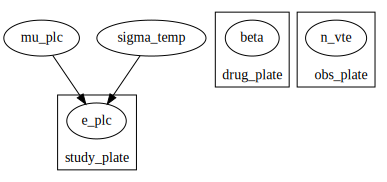

In [9]:
numpyro.render_model(model)

In [50]:
vars_n = ['beta', 'mu_plc', 'sigma']
az.summary(mcmc, var_names=vars_n)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.185,0.066,-0.306,-0.057,0.001,0.001,4343.0,5032.0,1.0
beta[1],-0.376,0.112,-0.594,-0.171,0.001,0.001,5823.0,5872.0,1.0
beta[2],-0.625,0.118,-0.844,-0.405,0.002,0.001,3696.0,4900.0,1.0
beta[3],-0.192,0.048,-0.277,-0.099,0.001,0.001,2567.0,3775.0,1.0
beta[4],-0.492,0.083,-0.651,-0.339,0.001,0.001,4544.0,6104.0,1.0
beta[5],-0.403,0.063,-0.526,-0.286,0.001,0.001,2947.0,3625.0,1.0
mu_plc,-0.201,0.010,-0.221,-0.183,0.000,0.000,9255.0,6166.0,1.0
sigma,0.493,0.098,0.322,0.678,0.001,0.001,5057.0,5368.0,1.0


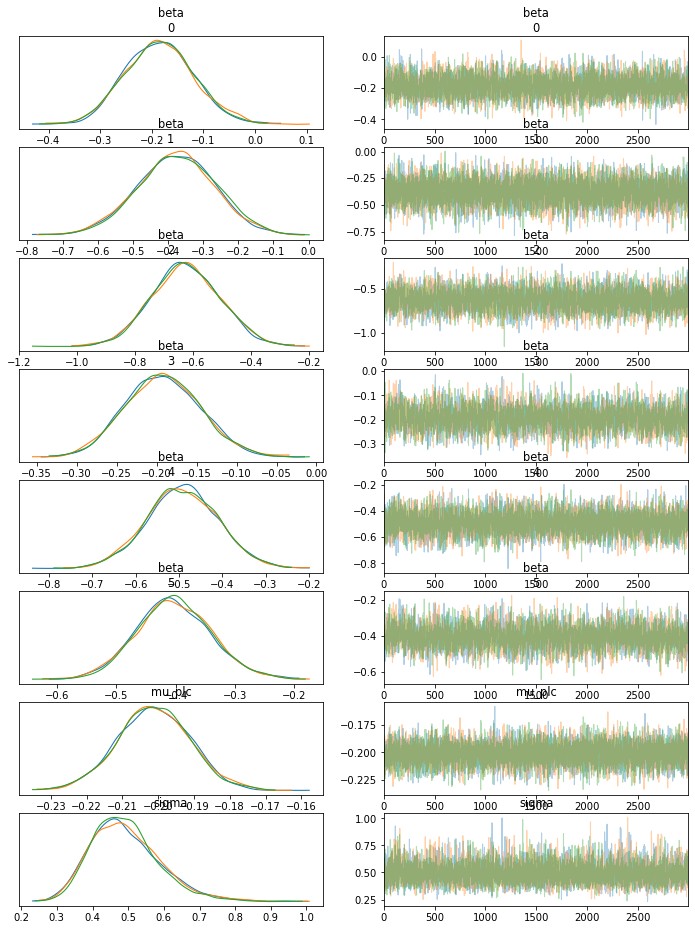

In [51]:
az.plot_trace(mcmc, var_names=vars_n, compact=False)
plt.show()

### Posterior Prediction for New Observations in SAME Study

In [14]:
## Posterior Prediction for New Observations
## in SAME Study
pred = Predictive(model=mcmc.sampler.model, posterior_samples=mcmc.get_samples())
post_pred_samples = pred(random.PRNGKey(12))
post_pred_samples

{'logit_p': DeviceArray([[-0.85602796, -0.9348727 , -0.9815558 , ..., -1.2047973 ,
               -1.478196  , -0.5441549 ],
              [-0.9877807 , -1.0884819 , -1.148106  , ..., -0.96300626,
               -1.192275  , -0.42874017],
              [-0.9589618 , -1.1122999 , -1.2030897 , ..., -0.938552  ,
               -1.0923343 , -0.8609809 ],
              ...,
              [-1.1102563 , -1.2638258 , -1.3547525 , ..., -1.6067789 ,
               -2.0188518 , -0.20080526],
              [-1.041727  , -1.084437  , -1.1097251 , ..., -0.6862263 ,
               -0.9866412 ,  0.03839642],
              [-1.0293142 , -1.148937  , -1.2197642 , ..., -1.3266152 ,
               -1.6194316 , -0.53102285]], dtype=float32),
 'logit_p_pred': DeviceArray([[-0.85602796, -0.9348727 , -0.9815558 , ..., -1.2047973 ,
               -1.478196  , -0.5441549 ],
              [-0.9877807 , -1.0884819 , -1.148106  , ..., -0.96300626,
               -1.192275  , -0.42874017],
              [-0.9589618

In [88]:
pred_frac = np.exp(post_pred_samples['logit_p'])/(1+np.exp(post_pred_samples['logit_p']))

predictions = pd.DataFrame({
    "study": merged_data['study'],
    "drug": merged_data['drug'],
    "daily_dose": merged_data['daily dose'],
    "true_events": merged_data['events'],
    "true_frac": merged_data['frac'],
    "pred_frac_mean": pred_frac.mean(0),
    "pred_frac_perc_5": np.percentile(pred_frac, 2.5, axis=0),
    "pred_frac_perc_95": np.percentile(pred_frac, 97.5, axis=0)
})
predictions.head()

,study,drug,daily_dose,true_events,true_frac,pred_frac_mean,pred_frac_perc_5,pred_frac_perc_95
0,5,LY517717,25,11,0.423077,0.278551,0.230310,0.329754
1,5,LY517717,50,8,0.400000,0.254262,0.209579,0.301778
2,5,LY517717,75,12,0.545455,0.240642,0.195437,0.288569
3,5,LY517717,100,13,0.188406,0.231285,0.184895,0.281703
4,5,LY517717,125,15,0.187500,0.224213,0.176629,0.276146


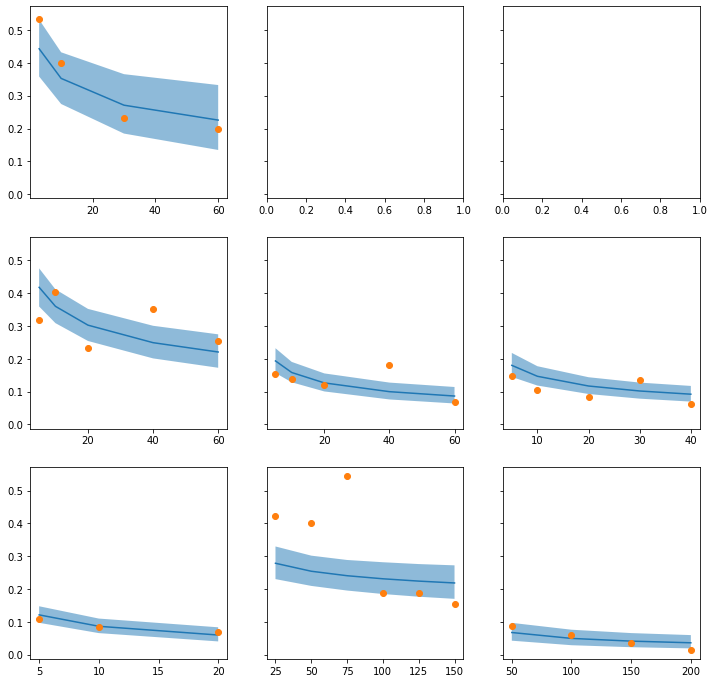

In [89]:
fig, ax = plt.subplots(3,3, figsize=(12,12), sharey=True)

# YM150
subset = predictions[predictions["drug"]== "YM150"].sort_values(by="daily_dose")
ax[0,0].plot(subset["daily_dose"], subset["pred_frac_mean"])
ax[0,0].fill_between(subset["daily_dose"], 
                     subset["pred_frac_perc_5"], 
                     subset["pred_frac_perc_95"],
                     alpha=0.5)
ax[0,0].plot(subset["daily_dose"], subset["true_frac"], "o")

# rivaroxaban study 1
subset = predictions[(predictions["drug"]== "rivaroxaban") & 
                     (predictions["study"]==1)].sort_values(by="daily_dose")
ax[1,0].plot(subset["daily_dose"], subset["pred_frac_mean"])
ax[1,0].fill_between(subset["daily_dose"], 
                     subset["pred_frac_perc_5"], 
                     subset["pred_frac_perc_95"],
                     alpha=0.5)
ax[1,0].plot(subset["daily_dose"], subset["true_frac"], "o")

# rivaroxaban study 2
subset = predictions[(predictions["drug"]== "rivaroxaban") & 
                     (predictions["study"]==2)].sort_values(by="daily_dose")
ax[1,1].plot(subset["daily_dose"], subset["pred_frac_mean"])
ax[1,1].fill_between(subset["daily_dose"], 
                     subset["pred_frac_perc_5"], 
                     subset["pred_frac_perc_95"],
                     alpha=0.5)
ax[1,1].plot(subset["daily_dose"], subset["true_frac"], "o")

# rivaroxaban study 3
subset = predictions[(predictions["drug"]== "rivaroxaban") & 
                     (predictions["study"]==3)].sort_values(by="daily_dose")
ax[1,2].plot(subset["daily_dose"], subset["pred_frac_mean"])
ax[1,2].fill_between(subset["daily_dose"], 
                     subset["pred_frac_perc_5"], 
                     subset["pred_frac_perc_95"],
                     alpha=0.5)
ax[1,2].plot(subset["daily_dose"], subset["true_frac"], "o")

# apixaban study 4
subset = predictions[(predictions["drug"]== "apixaban") & 
                     (predictions["study"]==4)].sort_values(by="daily_dose")
ax[2,0].plot(subset["daily_dose"], subset["pred_frac_mean"])
ax[2,0].fill_between(subset["daily_dose"], 
                     subset["pred_frac_perc_5"], 
                     subset["pred_frac_perc_95"],
                     alpha=0.5)
ax[2,0].plot(subset["daily_dose"], subset["true_frac"], "o")

# LY517717 study 5
subset = predictions[(predictions["drug"]== "LY517717") & 
                     (predictions["study"]==5)].sort_values(by="daily_dose")
ax[2,1].plot(subset["daily_dose"], subset["pred_frac_mean"])
ax[2,1].fill_between(subset["daily_dose"], 
                     subset["pred_frac_perc_5"], 
                     subset["pred_frac_perc_95"],
                     alpha=0.5)
ax[2,1].plot(subset["daily_dose"], subset["true_frac"], "o")

# razaxaban study 6
subset = predictions[(predictions["drug"]== "razaxaban") & 
                     (predictions["study"]==6)].sort_values(by="daily_dose")
ax[2,2].plot(subset["daily_dose"], subset["pred_frac_mean"])
ax[2,2].fill_between(subset["daily_dose"], 
                     subset["pred_frac_perc_5"], 
                     subset["pred_frac_perc_95"],
                     alpha=0.5)
ax[2,2].plot(subset["daily_dose"], subset["true_frac"], "o")

In [22]:
## Posterior Prediction for NEW Observations
## in NEW Study of SAME design

pred = Predictive(model=mcmc.sampler.model, posterior_samples=mcmc.get_samples())
post_pred_samples = pred(random.PRNGKey(12))
post_pred_samples

{'logit_p': DeviceArray([[-0.85602796, -0.9348727 , -0.9815558 , ..., -1.2047973 ,
               -1.478196  , -0.5441549 ],
              [-0.9877807 , -1.0884819 , -1.148106  , ..., -0.96300626,
               -1.192275  , -0.42874017],
              [-0.9589618 , -1.1122999 , -1.2030897 , ..., -0.938552  ,
               -1.0923343 , -0.8609809 ],
              ...,
              [-1.1102563 , -1.2638258 , -1.3547525 , ..., -1.6067789 ,
               -2.0188518 , -0.20080526],
              [-1.041727  , -1.084437  , -1.1097251 , ..., -0.6862263 ,
               -0.9866412 ,  0.03839642],
              [-1.0293142 , -1.148937  , -1.2197642 , ..., -1.3266152 ,
               -1.6194316 , -0.53102285]], dtype=float32),
 'logit_p_pred': DeviceArray([[-0.85602796, -0.9348727 , -0.9815558 , ..., -1.2047973 ,
               -1.478196  , -0.5441549 ],
              [-0.9877807 , -1.0884819 , -1.148106  , ..., -0.96300626,
               -1.192275  , -0.42874017],
              [-0.9589618

In [23]:
pred_n_vte = post_pred_samples['n_vte']

predictions = pd.DataFrame({
    "study": merged_data['study'],
    "drug": merged_data['drug'],
    "daily_dose": merged_data['daily dose'],
    "true_events": merged_data['events'],
    "true_frac": merged_data['frac'],
    "pred_events_mean": pred_n_vte.mean(0),
    "pred_events_perc_5": np.percentile(pred_n_vte, 2.5, axis=0),
    "pred_events_perc_95": np.percentile(pred_n_vte, 97.5, axis=0),
    "n": merged_data["n"]
})
predictions.head()

,study,drug,daily_dose,true_events,true_frac,pred_events_mean,pred_events_perc_5,pred_events_perc_95,n
0,5,LY517717,25,11,0.423077,7.240334,3.0,12.0,26
1,5,LY517717,50,8,0.400000,5.076445,2.0,9.0,20
2,5,LY517717,75,12,0.545455,5.264111,2.0,10.0,22
3,5,LY517717,100,13,0.188406,15.940001,9.0,24.0,69
4,5,LY517717,125,15,0.187500,17.955111,10.0,26.0,80


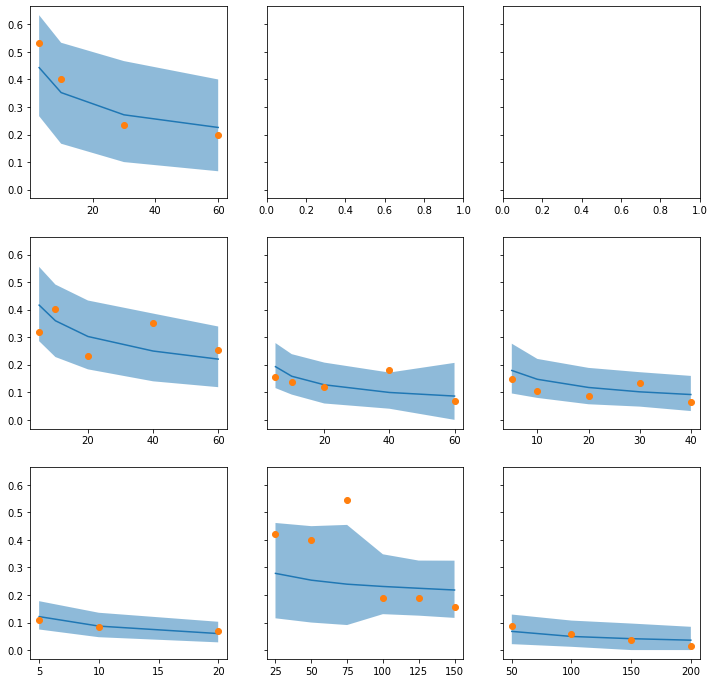

In [28]:
fig, ax = plt.subplots(3,3, figsize=(12,12), sharey=True)

# YM150
subset = predictions[predictions["drug"]== "YM150"].sort_values(by="daily_dose")
ax[0,0].plot(subset["daily_dose"], subset["pred_events_mean"]/subset["n"])
ax[0,0].fill_between(subset["daily_dose"], 
                     subset["pred_events_perc_5"]/subset["n"], 
                     subset["pred_events_perc_95"]/subset["n"],
                     alpha=0.5)
ax[0,0].plot(subset["daily_dose"], subset["true_frac"], "o")

# rivaroxaban study 1
subset = predictions[(predictions["drug"]== "rivaroxaban") & 
                     (predictions["study"]==1)].sort_values(by="daily_dose")
ax[1,0].plot(subset["daily_dose"], subset["pred_events_mean"]/subset["n"])
ax[1,0].fill_between(subset["daily_dose"], 
                     subset["pred_events_perc_5"]/subset["n"], 
                     subset["pred_events_perc_95"]/subset["n"],
                     alpha=0.5)
ax[1,0].plot(subset["daily_dose"], subset["true_frac"], "o")

# rivaroxaban study 2
subset = predictions[(predictions["drug"]== "rivaroxaban") & 
                     (predictions["study"]==2)].sort_values(by="daily_dose")
ax[1,1].plot(subset["daily_dose"], subset["pred_events_mean"]/subset["n"])
ax[1,1].fill_between(subset["daily_dose"], 
                     subset["pred_events_perc_5"]/subset["n"], 
                     subset["pred_events_perc_95"]/subset["n"],
                     alpha=0.5)
ax[1,1].plot(subset["daily_dose"], subset["true_frac"], "o")

# rivaroxaban study 3
subset = predictions[(predictions["drug"]== "rivaroxaban") & 
                     (predictions["study"]==3)].sort_values(by="daily_dose")
ax[1,2].plot(subset["daily_dose"], subset["pred_events_mean"]/subset["n"])
ax[1,2].fill_between(subset["daily_dose"], 
                     subset["pred_events_perc_5"]/subset["n"], 
                     subset["pred_events_perc_95"]/subset["n"],
                     alpha=0.5)
ax[1,2].plot(subset["daily_dose"], subset["true_frac"], "o")

# apixaban study 4
subset = predictions[(predictions["drug"]== "apixaban") & 
                     (predictions["study"]==4)].sort_values(by="daily_dose")
ax[2,0].plot(subset["daily_dose"], subset["pred_events_mean"]/subset["n"])
ax[2,0].fill_between(subset["daily_dose"], 
                     subset["pred_events_perc_5"]/subset["n"], 
                     subset["pred_events_perc_95"]/subset["n"],
                     alpha=0.5)
ax[2,0].plot(subset["daily_dose"], subset["true_frac"], "o")

# LY517717 study 5
subset = predictions[(predictions["drug"]== "LY517717") & 
                     (predictions["study"]==5)].sort_values(by="daily_dose")
ax[2,1].plot(subset["daily_dose"], subset["pred_events_mean"]/subset["n"])
ax[2,1].fill_between(subset["daily_dose"], 
                     subset["pred_events_perc_5"]/subset["n"], 
                     subset["pred_events_perc_95"]/subset["n"],
                     alpha=0.5)
ax[2,1].plot(subset["daily_dose"], subset["true_frac"], "o")

# razaxaban study 6
subset = predictions[(predictions["drug"]== "razaxaban") & 
                     (predictions["study"]==6)].sort_values(by="daily_dose")
ax[2,2].plot(subset["daily_dose"], subset["pred_events_mean"]/subset["n"])
ax[2,2].fill_between(subset["daily_dose"], 
                     subset["pred_events_perc_5"]/subset["n"], 
                     subset["pred_events_perc_95"]/subset["n"],
                     alpha=0.5)
ax[2,2].plot(subset["daily_dose"], subset["true_frac"], "o")